<a href="https://colab.research.google.com/github/HawksOkeyoJr/Numerical_Computing/blob/master/TPB_FEB_2021_TEST_Catboost_n__XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --no-warn-conflicts -q --upgrade xgboost

     |████████████████████████████████| 157.5MB 95kB/s 


In [ ]:
!pip install --no-warn-conflicts -q --upgrade catboost

     |████████████████████████████████| 65.7MB 50kB/s 


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from functools import partial
from xgboost import DMatrix
import lightgbm as lgbm
import xgboost as xgb 
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [ ]:
#train = pd.read_csv('../input/tabular-playground-series-feb-2021/train.csv')
#test = pd.read_csv('../input/tabular-playground-series-feb-2021/test.csv')

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
#!kaggle competitions download -c tabular-playground-series-feb-2021
dataset_url = 'https://www.kaggle.com/c/tabular-playground-series-feb-2021'#/data'

In [ ]:
 # WIth the kaggle key downloaded and set on your working directory, 
# the username and key will be picked autmatically
od.download(dataset_url)

  8%|▊         | 5.00M/65.7M [00:00<00:01, 41.4MB/s]

100%|██████████| 65.7M/65.7M [00:00<00:00, 125MB/s] 

In [ ]:
# Extract from archive
#with tarfile.open('/tabular-playground-series-feb-2021/tabular-playground-series-feb-2021.zip', 'r:gz') as tar:
#    tar.extractall(path='./data')
path_to_zip_file = '/content/tabular-playground-series-feb-2021/tabular-playground-series-feb-2021.zip'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')


In [ ]:
# Look into the data directory
#data_dir = './data/cifar10'
#print(os.listdir(data_dir))
#classes = os.listdir(data_dir + "/train")
#print(classes)
train_set = 'train.csv'
test_set = 'test.csv'

In [ ]:
# Download the data
dataframe_train = pd.read_csv(train_set, index_col=0)
dataframe_test = pd.read_csv(test_set, index_col=0)
dataframe_train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
2,B,A,A,A,B,B,A,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
3,A,A,A,C,B,D,A,B,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
4,A,A,A,C,B,D,A,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
6,A,B,A,A,B,B,A,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


## Categorical values supression

In [ ]:
dataframe_train['cat3'] = dataframe_train.cat3.map(lambda x: 'D' if x == 'B' else x )
dataframe_test['cat3'] = dataframe_test.cat3.map(lambda x: 'D' if x == 'B' else x )
#
dataframe_train['cat4'] = dataframe_train.cat4.map(lambda x: 'A' if x == 'D' or x=='C' else x )
dataframe_test['cat4'] = dataframe_test.cat4.map(lambda x: 'A' if x == 'D' or x=='C' else x)
#
dataframe_train['cat5'] = dataframe_train.cat5.map(lambda x: 'C' if x == ('A') else x)
dataframe_test['cat5'] = dataframe_test.cat5.map(lambda x: 'C' if x == ('A') else x)
#
dataframe_train['cat6'] = dataframe_train.cat6.map(lambda x: 'B' if x == 'D' or x=='C' or x=='E' or x=='I' or x=='G' or x=='H' else x)
dataframe_test['cat6'] = dataframe_test.cat6.map(lambda x: 'B' if x == 'D' or x=='C' or x=='E' or x=='I' or x=='G' or x=='H' else x)
#
dataframe_train['cat7'] = dataframe_train.cat7.map(lambda x: 'D' if x == 'B' or x=='G' or x=='F' or x=='A' or x=='C' or x=='I' else x)
dataframe_test['cat7'] = dataframe_test.cat7.map(lambda x: 'D' if x == 'B' or x=='G' or x=='F' or x=='A' or x=='C' or x=='I' else x)
#
dataframe_train['cat8'] = dataframe_train.cat8.map(lambda x: 'E' if x == 'B' or x=='F' or x=='D' else x)
dataframe_test['cat8'] = dataframe_test.cat8.map(lambda x: 'E' if x == 'B' or x=='F' or x=='D' else x)
#
dataframe_train['cat9'] = dataframe_train.cat9.map(lambda x: 'B' if x == 'C' or x=='E' or x=='D' else x)
dataframe_test['cat9'] = dataframe_test.cat9.map(lambda x: 'B' if x == 'C' or x=='E' or x=='D' else x)

In [ ]:
train = dataframe_train.copy()
test = dataframe_test.copy()

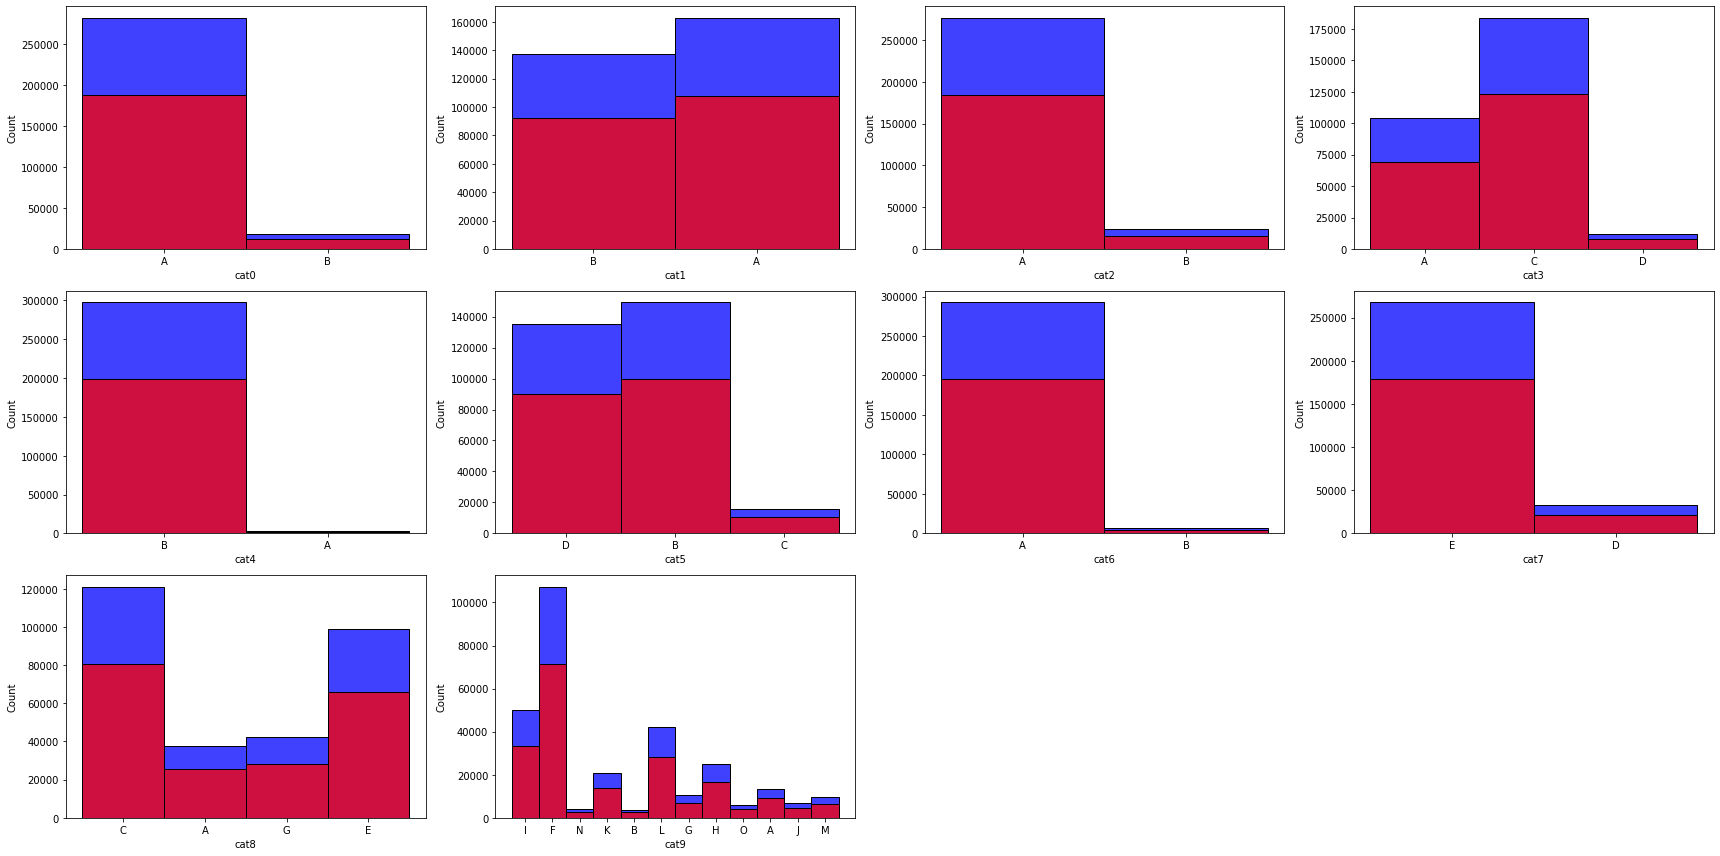

In [ ]:
num_rows, num_cols = 3,4
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(24, 12))
#f.suptitle('Distribution of Features', fontsize=16)

for index, column in enumerate([feature for feature in train.columns if 'cat' in feature]):
    i,j = (index // num_cols, index % num_cols)
    sns.histplot(x=column, data=dataframe_train, ax=axes[i,j], color='b')
    sns.histplot(x=column, data=dataframe_test, ax=axes[i,j], color='r')

f.delaxes(axes[2, 2])
f.delaxes(axes[2, 3])
plt.tight_layout()
plt.show()

In [ ]:
train = train.drop(['cat4', 'cat6'], axis=1)
test = test.drop(['cat4', 'cat6'], axis=1)

In [ ]:
train.head()

,cat0,cat1,cat2,cat3,cat5,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,D,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
2,B,A,A,A,B,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
3,A,A,A,C,D,D,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
4,A,A,A,C,D,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
6,A,B,A,A,B,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [ ]:
X_train = train.drop(['target'], axis=1)
y_train = train.target
X_test = test.copy()

In [ ]:
#y_train.max(), len(y_train[y_train < 6.]), len(y_train[(y_train > 6) & (y_train < 9.5)])

In [ ]:
cat_cols = [feature for feature in train.columns if 'cat' in feature]
cont_cols = [feature for feature in train.columns if 'con' in feature]

for feature in cat_cols:
    le = LabelEncoder()
    le.fit(train[feature])
    X_train[feature] = le.transform(X_train[feature])
    X_test[feature] = le.transform(X_test[feature])

## Case #1
### Start the standadisation process & round off to the nearest 3


In [ ]:
 # Turn the data to a Numpy array
 X_train_array = X_train[X_train.columns.to_list()].to_numpy()
 X_test_array = X_test[X_train.columns.to_list()].to_numpy()
 y_train_array = y_train.to_numpy()

In [ ]:
# Standardisation of the data:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
sc = StandardScaler()
#sc = PowerTransformer()
X_train_array_std = sc.fit_transform(X_train_array, y_train_array)
X_test_array_std = sc.transform(X_test_array)

In [ ]:
#Round off the data to the nearest 3 decimals
X_train_array_std=np.round(X_train_array_std, 3)
X_test_array_std=np.round(X_test_array_std, 3)

In [ ]:
# Return the data back to a pandas dataFrame format
X_train = pd.DataFrame(X_train_array_std, columns=X_train.columns.to_list())
X_test = pd.DataFrame(X_test_array_std, columns=X_train.columns.to_list())
y_train = train.target

In [ ]:
X_train.head()

,cat0,cat1,cat2,cat3,cat5,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,-0.257,1.088,-0.291,-1.279,1.077,0.348,-0.547,0.215,1.945,0.758,-1.598,-0.957,-0.867,1.610,-0.295,1.396,1.978,1.351,1.089,0.745,1.598,0.962
1,3.898,-0.919,-0.291,-1.279,-0.980,0.348,-1.677,-0.875,-0.425,-2.093,-0.433,1.676,-0.863,-0.295,-0.687,-0.868,0.608,0.094,0.537,0.915,-0.896,1.355
2,-0.257,-0.919,-0.291,0.572,1.077,-2.875,-0.547,2.030,1.013,1.077,0.053,1.537,-0.806,1.752,-0.565,1.842,1.841,1.462,-1.195,0.717,1.560,1.443
3,-0.257,-0.919,-0.291,0.572,1.077,0.348,1.712,0.941,0.881,1.126,-1.451,1.201,1.566,1.838,0.523,-0.238,1.853,1.311,-0.053,0.729,1.291,0.495
4,-0.257,1.088,-0.291,-1.279,-0.980,0.348,-0.547,-0.875,-0.188,0.564,0.260,-0.386,-0.879,-0.543,1.183,-0.639,-0.083,-0.317,1.089,0.663,-0.820,-0.913


In [ ]:
X_train.index = dataframe_train.index
X_train.head()

,cat0,cat1,cat2,cat3,cat5,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,,
1,-0.257,1.088,-0.291,-1.279,1.077,0.348,-0.547,0.215,1.945,0.758,-1.598,-0.957,-0.867,1.610,-0.295,1.396,1.978,1.351,1.089,0.745,1.598,0.962
2,3.898,-0.919,-0.291,-1.279,-0.980,0.348,-1.677,-0.875,-0.425,-2.093,-0.433,1.676,-0.863,-0.295,-0.687,-0.868,0.608,0.094,0.537,0.915,-0.896,1.355
3,-0.257,-0.919,-0.291,0.572,1.077,-2.875,-0.547,2.030,1.013,1.077,0.053,1.537,-0.806,1.752,-0.565,1.842,1.841,1.462,-1.195,0.717,1.560,1.443
4,-0.257,-0.919,-0.291,0.572,1.077,0.348,1.712,0.941,0.881,1.126,-1.451,1.201,1.566,1.838,0.523,-0.238,1.853,1.311,-0.053,0.729,1.291,0.495
6,-0.257,1.088,-0.291,-1.279,-0.980,0.348,-0.547,-0.875,-0.188,0.564,0.260,-0.386,-0.879,-0.543,1.183,-0.639,-0.083,-0.317,1.089,0.663,-0.820,-0.913


In [ ]:
X_test.head()

,cat0,cat1,cat2,cat3,cat5,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,-0.257,1.088,-0.291,0.572,1.077,0.348,0.582,-0.511,-0.944,0.189,0.211,-1.216,1.227,0.376,-0.995,-0.861,-1.165,-1.393,-1.091,-1.151,0.584,-0.892
1,-0.257,1.088,-0.291,0.572,1.077,0.348,-0.547,1.304,-0.597,0.471,-0.736,-1.084,-0.887,-0.124,-0.420,0.102,1.803,-0.051,0.283,0.869,-0.933,1.034
2,-0.257,1.088,-0.291,0.572,1.077,0.348,-0.547,-0.875,0.029,0.474,1.583,-1.032,-0.877,0.726,1.127,-0.991,0.578,0.106,1.644,0.996,-0.865,-1.019
3,-0.257,-0.919,3.434,-1.279,1.077,0.348,0.582,-0.875,-0.415,-0.082,1.358,-1.062,0.120,1.086,-1.238,-0.772,-0.076,0.342,-0.451,-1.189,0.292,-0.851
4,-0.257,1.088,-0.291,-1.279,-0.980,0.348,0.582,0.215,-0.658,1.046,-0.644,-1.066,1.507,-1.287,-0.772,0.786,-1.309,-1.292,1.022,-1.325,-1.081,1.295


In [ ]:
y_train.shape, X_train.shape, X_test.shape

((300000,), (300000, 22), (200000, 22))

## Case #2
From the above data, cut of the target tails

In [ ]:
temp = X_train.copy()
temp['target'] =dataframe_train.target
temp.head(), temp.shape, temp.tail()

(     cat0   cat1   cat2   cat3   cat5  ...  cont10  cont11  cont12  cont13    target
 id                                     ...                                          
 1  -0.257  1.088 -0.291 -1.279  1.077  ...   1.089   0.745   1.598   0.962  6.994023
 2   3.898 -0.919 -0.291 -1.279 -0.980  ...   0.537   0.915  -0.896   1.355  8.071256
 3  -0.257 -0.919 -0.291  0.572  1.077  ...  -1.195   0.717   1.560   1.443  5.760456
 4  -0.257 -0.919 -0.291  0.572  1.077  ...  -0.053   0.729   1.291   0.495  7.806457
 6  -0.257  1.088 -0.291 -1.279 -0.980  ...   1.089   0.663  -0.820  -0.913  6.868974
 
 [5 rows x 23 columns],
 (300000, 23),
          cat0   cat1   cat2   cat3  ...  cont11  cont12  cont13    target
 id                                  ...                                  
 499993 -0.257  1.088 -0.291  0.572  ...  -0.634  -1.400   1.289  8.343538
 499996 -0.257  1.088 -0.291  0.572  ...  -0.888  -0.985  -1.210  7.851861
 499997 -0.257  1.088 -0.291  0.572  ...  -0.924  -1.242 

In [ ]:
#From the distribution graph, I would like to get rid of rows which has target < 5 and > 10 to minimize outlier.
# Temp
#temp = X_train.copy()
#temp['target'] =train.target
#temp_train = temp[(temp.target > 5) & (temp.target < 9.5)]
####=======================
#temp_train.shape

##Data augmentation Pandas
Increase samples
add 0.1

In [ ]:
#y_train.head()
#y_train = np.round(y_train, 3)

In [ ]:
temp_train_samp = temp.sample(frac=0.25)
temp_train_samp[temp.columns[:-1]] +=0.01
temp_train_samp.head()

,cat0,cat1,cat2,cat3,cat5,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,,,
36207,-0.247,1.098,-0.281,0.582,1.087,-2.865,1.722,0.588,2.098,-1.943,-0.370,1.575,-0.872,1.121,0.476,1.326,1.850,1.219,0.424,0.213,-0.073,-1.007,6.849302
132212,-0.247,-0.909,-0.281,0.582,-0.970,0.358,-0.537,-0.865,-0.150,1.128,0.581,-0.971,-0.872,-0.707,-0.217,-0.922,-0.592,-0.910,0.485,-1.459,-0.802,1.386,8.478357
101029,-0.247,1.098,-0.281,-1.269,1.087,0.358,0.592,0.951,-2.749,0.603,0.269,-0.034,-0.567,-0.557,-0.627,-0.661,-0.726,-0.615,-1.169,-1.393,0.319,-0.192,7.026908
305531,-0.247,-0.909,-0.281,0.582,1.087,-2.865,-1.667,0.225,1.881,0.474,-1.389,-0.853,-0.867,1.719,0.412,1.397,2.102,1.451,1.609,1.401,1.600,-0.753,7.455387
76761,-0.247,-0.909,-0.281,-1.269,-0.970,0.358,-1.667,-0.865,-0.331,0.700,2.492,0.311,-0.856,-0.521,-0.513,-0.786,-0.654,-0.914,-0.192,1.230,-0.784,1.359,8.074857


In [ ]:
temp_train_samp.index +=500000

In [ ]:
temp_train_samp.head()

,cat0,cat1,cat2,cat3,cat5,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,,,
536207,-0.247,1.098,-0.281,0.582,1.087,-2.865,1.722,0.588,2.098,-1.943,-0.370,1.575,-0.872,1.121,0.476,1.326,1.850,1.219,0.424,0.213,-0.073,-1.007,6.849302
632212,-0.247,-0.909,-0.281,0.582,-0.970,0.358,-0.537,-0.865,-0.150,1.128,0.581,-0.971,-0.872,-0.707,-0.217,-0.922,-0.592,-0.910,0.485,-1.459,-0.802,1.386,8.478357
601029,-0.247,1.098,-0.281,-1.269,1.087,0.358,0.592,0.951,-2.749,0.603,0.269,-0.034,-0.567,-0.557,-0.627,-0.661,-0.726,-0.615,-1.169,-1.393,0.319,-0.192,7.026908
805531,-0.247,-0.909,-0.281,0.582,1.087,-2.865,-1.667,0.225,1.881,0.474,-1.389,-0.853,-0.867,1.719,0.412,1.397,2.102,1.451,1.609,1.401,1.600,-0.753,7.455387
576761,-0.247,-0.909,-0.281,-1.269,-0.970,0.358,-1.667,-0.865,-0.331,0.700,2.492,0.311,-0.856,-0.521,-0.513,-0.786,-0.654,-0.914,-0.192,1.230,-0.784,1.359,8.074857


In [ ]:
temp_train_samp.shape

(75000, 23)

In [ ]:
temp_train_comb = pd.concat([temp, temp_train_samp])#, ignore_index=True)
temp_train_comb.shape

(375000, 23)

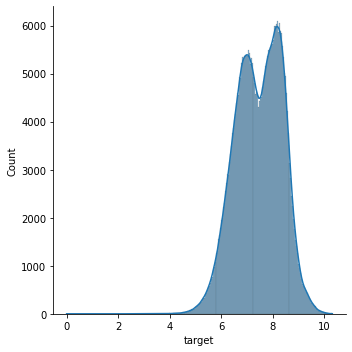

In [ ]:
sns.displot(data=temp_train_comb, x="target", kde=True)

In [ ]:
X_train = temp_train_comb.drop(['target'], axis=1)
X_test = X_test
y_train = temp_train_comb.target

In [ ]:
y_train.head()

id
1    6.994023
2    8.071256
3    5.760456
4    7.806457
6    6.868974
Name: target, dtype: float64

In [ ]:
y_train.shape, X_train.shape, X_test.shape

((375000,), (375000, 22), (200000, 22))

In [ ]:
seed = 0
n_splits = 5
shuffle=True
iterations = 50000
early_stopping_rounds = 400
verbose_eval = 0
baseline_rounds = 5
cb_learning_rate = 0.006
xgb_learning_rate = 0.01

In [ ]:
split = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [ ]:
cb_params = {'iterations':iterations,
             'learning_rate':cb_learning_rate,
             'depth':7,
             'bootstrap_type':'Bernoulli',
             'random_strength':1,
             'min_data_in_leaf':10,
             'l2_leaf_reg':3,
             'loss_function':'RMSE', 
             'eval_metric':'RMSE',
             'random_seed':seed,
             'grow_policy':'Depthwise',
             'max_bin':1024, 
             'model_size_reg': 0,
             'task_type': 'GPU',
             'od_type':'IncToDec',
             'od_wait':100,
             'metric_period':500,
             'verbose':verbose_eval,
             'subsample':0.8,
             'od_pval':1e-10,
             'max_ctr_complexity': 8,
             'has_time': False,
             'simple_ctr' : 'FeatureFreq',
             'combinations_ctr': 'FeatureFreq'
            }

xgb_params= {'objective': 'reg:squarederror',
             'max_depth': 6,
             'eta': xgb_learning_rate,
             'colsample_bytree': 0.4,
             'subsample': 0.6,
             'reg_alpha' : 6,
             'min_child_weight': 100,
             'n_jobs': 2,
             'seed': 2001,
             'tree_method': 'gpu_hist',
             'gpu_id': 0,
             'predictor': 'gpu_predictor',
            }

lgbm_params = {'max_depth': 16,
               'subsample': 0.8032697250789377, 
               'colsample_bytree': 0.21067140508531404,
               'learning_rate': 0.009867383057779643,
               'reg_lambda': 10.987474846877767,
               'reg_alpha': 17.335285595031994,
               'min_child_samples': 31, 
               'num_leaves': 66,
               'max_bin': 522,
               'cat_smooth': 81,
               'cat_l2': 0.029690334194270022,
               'metric': 'rmse',
               'n_jobs': -1, 
               'verbose':-1,
               'n_estimators': iterations
              }

In [ ]:
preds_list = []
oof_cb = np.zeros((len(y_train)))
oof_xgb = np.zeros((len(y_train)))
oof_cbx = np.zeros((len(y_train)))
oof_xgbx = np.zeros((len(y_train)))
oof_lgb = np.zeros((len(y_train)))
oof_lgb_incremental = np.zeros((len(y_train)))

for fold, (train_idx, val_idx) in enumerate(split.split(X_train)):
    print(f'Fold {fold+1}')
    X_tr = X_train.iloc[train_idx]
    X_val = X_train.iloc[val_idx]
    y_tr = y_train.iloc[train_idx]
    y_val = y_train.iloc[val_idx]
   
    #ptrain = Pool(data=X_tr, label=y_tr, cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ptrain = Pool(data=X_tr, label=y_tr)#, cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    pvalid = Pool(data=X_val, label=y_val)#, cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ptest = Pool(data=X_test)#, cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    CModel = CatBoostRegressor(**cb_params)
    CModel.fit(ptrain,
               eval_set=pvalid,
               use_best_model=True,
               early_stopping_rounds=early_stopping_rounds)
    temp_fold_preds = CModel.predict(pvalid)
    oof_cb[val_idx] = temp_fold_preds
    first_cb_rmse = mean_squared_error(y_val, temp_fold_preds, squared=False)
    print(f'RMSE of CB model is {first_cb_rmse}')
    baseline_preds_tr_cb = CModel.predict(ptrain)
    baseline_preds_vl_cb = CModel.predict(pvalid)
    test_preds_cb = CModel.predict(ptest)   
    
    xtrain = DMatrix(data=X_tr, label=y_tr, nthread=2)
    xvalid = DMatrix(data=X_val, label=y_val, nthread=2)
    xtest = DMatrix(data=X_test, nthread=2)
    XModel = xgb.train(xgb_params, xtrain,
                       evals=[(xvalid,'validation')],
                       verbose_eval=verbose_eval,
                       early_stopping_rounds=early_stopping_rounds,
                       xgb_model=None,
                       num_boost_round=iterations)
    temp_fold_preds = XModel.predict(xvalid)
    oof_xgb[val_idx] = temp_fold_preds
    first_xgb_rmse = mean_squared_error(y_val, temp_fold_preds, squared=False)
    print(f'RMSE of XGB model is {first_xgb_rmse}')
    baseline_preds_tr_xgb = XModel.predict(xtrain)
    baseline_preds_vl_xgb = XModel.predict(xvalid)
    test_preds_xgb = XModel.predict(xtest)
    
#    ltrain = lgbm.Dataset(X_tr, label=y_tr, init_score=None, categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], free_raw_data=False)
    ltrain = lgbm.Dataset(X_tr, label=y_tr, init_score=None, free_raw_data=False)
    lvalid = lgbm.Dataset(X_val, label=y_val, init_score=None, free_raw_data=False)
    ltest =  lgbm.Dataset(X_test, label=y_val, init_score=None, free_raw_data=False)
    LModel = lgbm.train(lgbm_params,
                        train_set=ltrain,
                        num_boost_round=iterations,
                        valid_sets=lvalid, 
                        init_model=None,
                        early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=verbose_eval)           
    temp_fold_preds = LModel.predict(X_val)
    oof_lgb[val_idx] = temp_fold_preds
    first_lgb_rmse = mean_squared_error(y_val, temp_fold_preds, squared=False)
    print(f'RMSE of LGBM model is {first_lgb_rmse}')
    params = lgbm_params.copy()     
    params.update({'learning_rate': 0.003})
    for i in range(1, 8):
        if i > 2:                      
            params['reg_lambda'] *= 0.9
            params['reg_alpha']  *= 0.9
            params['num_leaves'] += 40                   
        
        LModel = lgbm.train(lgbm_params,
                            train_set=ltrain,
                            num_boost_round=iterations,
                            valid_sets=lvalid, 
                            init_model=LModel,
                            early_stopping_rounds=early_stopping_rounds,
                            verbose_eval=verbose_eval)           
    temp_fold_preds = LModel.predict(X_val)
    oof_lgb_incremental[val_idx] = temp_fold_preds
    second_lgb_rmse = mean_squared_error(y_val, temp_fold_preds, squared=False)
    print(f'RMSE of LGBM model is {second_lgb_rmse}')
    print(f'LGBM improvement using Incremental Improvements {first_lgb_rmse - second_lgb_rmse}')
    baseline_preds_tr_lgb = LModel.predict(X_tr)
    baseline_preds_vl_lgb = LModel.predict(X_val)
    test_preds_lgb = LModel.predict(X_test)
    
    baseline_train = (baseline_preds_tr_xgb+baseline_preds_tr_lgb+baseline_preds_tr_cb)/3
    baseline_valid = (baseline_preds_vl_xgb+baseline_preds_vl_lgb+baseline_preds_vl_cb)/3
    baseline_test = (test_preds_xgb+test_preds_lgb+test_preds_cb)/3
    
    for baseline in range(baseline_rounds):
        print(f'Using prediction of each model as a baseline for the next model round {baseline+1}')
        #ptrain = Pool(data=X_tr, label=y_tr, cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], baseline=baseline_train)
        ptrain = Pool(data=X_tr, label=y_tr, baseline=baseline_train)
        pvalid = Pool(data=X_val, label=y_val, baseline=baseline_valid)
        ptest = Pool(data=X_test, baseline=baseline_test)
        cb_params_ = cb_params.copy()
        cb_params_.update({'learning_rate': cb_learning_rate*(1/(baseline+1))})
        CModel = CatBoostRegressor(**cb_params_)
        CModel.fit(ptrain, 
                   eval_set=pvalid,
                   use_best_model=True,
                   early_stopping_rounds=early_stopping_rounds)
        temp_fold_preds = CModel.predict(pvalid)
        oof_cbx[val_idx] = temp_fold_preds
        second_cb_rmse = mean_squared_error(y_val, temp_fold_preds, squared=False)
        print(f'RMSE of CB model with baseline round {baseline+1} {second_cb_rmse}')   
        baseline_train = CModel.predict(ptrain)
        baseline_valid = CModel.predict(pvalid)
        baseline_test = CModel.predict(ptest)
    
        xtrain = DMatrix(data=X_tr, label=y_tr, base_margin=baseline_train)
        xvalid = DMatrix(data=X_val, label=y_val, base_margin=baseline_valid)
        xtest =  DMatrix(data=X_test, base_margin=baseline_test)
        xgb_params_ = xgb_params.copy()
        xgb_params_.update({'learning_rate': xgb_learning_rate*(1/(baseline+1))})
        XModel = xgb.train(xgb_params_, xtrain,
                           evals=[(xvalid,'validation')],
                           verbose_eval=verbose_eval,
                           early_stopping_rounds=early_stopping_rounds,
                           xgb_model=None,
                           num_boost_round=iterations)
        temp_fold_preds = XModel.predict(xvalid)
        oof_xgbx[val_idx] = temp_fold_preds
        second_xgb_rmse = mean_squared_error(y_val, temp_fold_preds, squared=False)
        print(f'RMSE of XGB model with baseline round {baseline+1} {second_xgb_rmse}')
        baseline_train = XModel.predict(xtrain)
        baseline_valid = XModel.predict(xvalid)
        baseline_test = XModel.predict(xtest)          
        print(f'CB Improvement  using Baseline round {baseline+1}: {first_cb_rmse - second_cb_rmse}')
        print(f'XGB Improvement using Baseline round {baseline+1}: {first_xgb_rmse - second_xgb_rmse}')
        first_cb_rmse = second_cb_rmse
        first_xgb_rmse = second_xgb_rmse
    print('-' * 100)
    print('',end='\n')
    preds_list.append(XModel.predict(xtest))

Fold 1
RMSE of CB model is 0.8023695250743932
RMSE of XGB model is 0.8212933745535275
RMSE of LGBM model is 0.8206118209327047
RMSE of LGBM model is 0.8206118209327047
LGBM improvement using Incremental Improvements 0.0
Using prediction of each model as a baseline for the next model round 1
RMSE of CB model with baseline round 1 0.7992933549917081
RMSE of XGB model with baseline round 1 0.7990400064798832
CB Improvement  using Baseline round 1: 0.0030761700826851257
XGB Improvement using Baseline round 1: 0.02225336807364431
Using prediction of each model as a baseline for the next model round 2
RMSE of CB model with baseline round 2 0.7954330717976622
RMSE of XGB model with baseline round 2 0.795410402843295
CB Improvement  using Baseline round 2: 0.003860283194045855
XGB Improvement using Baseline round 2: 0.0036296036365881523
Using prediction of each model as a baseline for the next model round 3
RMSE of CB model with baseline round 3 0.7935888660006001
RMSE of XGB model with basel

In [ ]:
first_cb_rmse = mean_squared_error(y_train, oof_cb, squared=False)
first_xgb_rmse = mean_squared_error(y_train, oof_xgb, squared=False)
first_lgb_rmse = mean_squared_error(y_train, oof_lgb, squared=False)
second_cb_rmse = mean_squared_error(y_train, oof_cbx, squared=False)
second_xgb_rmse = mean_squared_error(y_train, oof_xgbx, squared=False)
second_lgb_rmse = mean_squared_error(y_train, oof_lgb_incremental, squared=False)
print(f'RMSE for CB model is {first_cb_rmse}')
print(f'RMSE for XGB model is {first_xgb_rmse}')
print(f'RMSE for LGBM model is {first_lgb_rmse}')
print(f'RMSE for CB model with XGB baseline is {second_cb_rmse}')
print(f'RMSE for XGB model with CB baseline is {second_xgb_rmse}')
print(f'RMSE for LGBM model with Incremental Improvement is {second_lgb_rmse}')
print(f'RMSE for CB and XGB blend is {mean_squared_error(y_train, (oof_cbx+oof_xgbx)/2, squared=False)}')
print(f'RMSE for CB, XGB and LGBM blend is {mean_squared_error(y_train, (oof_cbx+oof_xgbx+oof_lgb_incremental)/3, squared=False)}')

Results from Baseline:

+ RMSE for CB model is 0.8433047853632898
+ RMSE for XGB model is 0.8423632223592155
+ RMSE for LGBM model is 0.8421403134782113
+ RMSE for CB model with XGB baseline is 0.8421404253442772
+ RMSE for XGB model with CB baseline is 0.8421611646170246
+ RMSE for LGBM model with Incremental Improvement is 0.8422742003236688
+ RMSE for CB and XGB blend is 0.8421505292079217
+ RMSE for CB, XGB and LGBM blend is 0.8419987140203177

In [ ]:
#preds_list.append(LModel.predict(X_test))
#RMSE for CB model is 0.8406611074247011
#RMSE for XGB model is 0.8418742386871497
#RMSE for LGBM model is 0.8421288059737446
#RMSE for CB model with XGB baseline is 0.8409397575458377
#RMSE for XGB model with CB baseline is 0.8409553342782192
#RMSE for LGBM model with Incremental Improvement is 0.8422944045294559
#RMSE for CB and XGB blend is 0.8409473706675149
#RMSE for CB, XGB and LGBM blend is 0.841131585517756

In [ ]:
 #preds_list.append(LModel.predict(xtest))

In [ ]:
preds = np.mean(preds_list, axis=0)
submission_mean = pd.DataFrame({'id':test.index,'target':preds})
#submission_mean = pd.DataFrame({'id':test.index,'target':preds_list})
submission_mean.to_csv('submission_mean_base_FeatureCompressed_dropped_sampled_v04.csv', index=False)
submission_mean.head()

In [ ]:
from google.colab import files
files.download('submission_mean_base_FeatureCompressed_dropped_sampled_v04.csv') 

In [ ]:

id	target
0	0	7.646254
1	5	7.785642
2	15	7.597903
3	16	7.506373
4	17	7.297190

In [ ]:
temp_train = submission_mean.copy()
temp_train = temp_train.drop(temp_train[(temp_train.target < 5) & (temp_train.target > 10)].index)
temp_train.shape

(200000, 2)

Another nice idea for more overfit. Blending with top public blend!
https://www.kaggle.com/somayyehgholami/comparative-method-tabular-feb-301

In [ ]:
sub_best = pd.read_csv('sample_submission.csv')
sub_final = submission_mean.copy()
sub_final['target'] = sub_best.target * 0.9 + submission_mean.target * 0.1
sub_final.to_csv('submission_blend_mean_base1.csv', index=False)
sub_final.head()

,id,target
0,0,1.213035
1,5,1.226492
2,15,1.208095
3,16,1.197074
4,17,1.179027
